In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import Metadata
from sdv.sequential import PARSynthesizer
from sdv.single_table import GaussianCopulaSynthesizer
from tabulate import tabulate
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from scipy.stats import jarque_bera
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from scipy.stats import jarque_bera
import seaborn as sns

In [67]:
#loading our datasets
first_data = pd.read_csv("First.csv")
second_data = pd.read_csv("Second.csv")
third_data = pd.read_csv("Third.csv")
#Merging the datasets
data = pd.concat([first_data, second_data, third_data], ignore_index=True)
data.head()


,No,Date/Time,Date/time end,Altitude [m],Size fraction,Mass v [µg/m**3],Na+ [µg/m**3],[NH4]+ [µg/m**3],K+ [µg/m**3],Mg2+ [µg/m**3],...,Cu [ng/m**3],Zn [ng/m**3],Pb [ng/m**3],As [ng/m**3],Se [ng/m**3],Sr [ng/m**3],Rb [ng/m**3],Ba [ng/m**3],La [ng/m**3],Ce [ng/m**3]
0,866,2010-01-11T16:30:00,2010-01-12T17:16,42,0.05 - 0.14 µm,0.063,0.0026,0.0061,<0.0006,<0.0006,...,0.17,0.21,<0.0228,0.003,<0.001,<0.0372,<0.0048,<0.0048,0.006,<0.006
1,867,2010-01-11T16:30:00,2010-01-12T17:16,42,0.14 - 0.42 µm,0.636,0.0661,0.0119,<0.0006,0.0056,...,0.16,0.09,0.026,0.025,0.002,0.051,0.011,<0.0048,0.057,<0.006
2,868,2010-01-11T16:30:00,2010-01-12T17:16,42,0.42 - 1.2 µm,5.886,0.6887,0.0016,0.02,0.0922,...,0.16,0.24,0.052,0.02,0.041,0.831,0.064,1.016,0.682,0.068
3,869,2010-01-11T16:30:00,2010-01-12T17:16,42,1.2 - 3.5 µm,28.971,6.7001,0.0021,0.2373,1.0962,...,0.34,0.43,0.055,0.168,0.096,3.35,0.331,4.086,2.026,0.318
4,870,2010-01-11T16:30:00,2010-01-12T17:16,42,3.5 - 10 µm,31.786,6.8745,0.0109,0.3071,1.1,...,0.25,0.41,0.063,0.079,0.004,4.179,0.425,1.977,1.578,0.562


In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 655 entries, 0 to 654
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   No                  655 non-null    int64  
 1   Date/Time           655 non-null    object 
 2   Date/time end       655 non-null    object 
 3   Altitude [m]        655 non-null    int64  
 4   Size fraction       655 non-null    object 
 5   Mass v [µg/m**3]    655 non-null    float64
 6   Na+ [µg/m**3]       655 non-null    object 
 7   [NH4]+ [µg/m**3]    655 non-null    object 
 8   K+ [µg/m**3]        655 non-null    object 
 9   Mg2+ [µg/m**3]      655 non-null    object 
 10  Ca2+ [µg/m**3]      655 non-null    object 
 11  Cl- [µg/m**3]       655 non-null    float64
 12  [NO3]- [µg/m**3]    655 non-null    object 
 13  [SO4]2- [µg/m**3]   655 non-null    float64
 14  [C2O4]2- [µg/m**3]  655 non-null    object 
 15  Br- [µg/m**3]       655 non-null    object 
 16  C org [µ

In [69]:
#checking missing values
print(data.isna().sum())
print("number of rows with missing values :", data.isna().any(axis=1).sum())

No                     0
Date/Time              0
Date/time end          0
Altitude [m]           0
Size fraction          0
Mass v [µg/m**3]       0
Na+ [µg/m**3]          0
[NH4]+ [µg/m**3]       0
K+ [µg/m**3]           0
Mg2+ [µg/m**3]         0
Ca2+ [µg/m**3]         0
Cl- [µg/m**3]          0
[NO3]- [µg/m**3]       0
[SO4]2- [µg/m**3]      0
[C2O4]2- [µg/m**3]     0
Br- [µg/m**3]          0
C org [µg/m**3]        3
EC [µg/m**3]           2
TC [µg/m**3]           1
Ca [ng/m**3]           8
Ti [ng/m**3]           8
V [ng/m**3]            8
Cr [ng/m**3]           8
Mn [ng/m**3]           8
Fe [ng/m**3]           8
Ni [ng/m**3]           8
Cu [ng/m**3]           8
Zn [ng/m**3]           8
Pb [ng/m**3]           9
As [ng/m**3]          10
Se [ng/m**3]          12
Sr [ng/m**3]           8
Rb [ng/m**3]           8
Ba [ng/m**3]          11
La [ng/m**3]          12
Ce [ng/m**3]           9
dtype: int64
number of rows with missing values : 26


In [70]:
#dropping missing values
data = data.dropna()
data.shape

(629, 36)

In [71]:
#checking the datetime data type 11:47:08 
Format = "%Y-%m-%dT%H:%M:%S"  

data[['Date/Time', 'Date/time end']] = data[['Date/Time', 'Date/time end']].apply(lambda x: x.str.strip())
# Preprocess 'Date/time end' to add seconds if missing
data['Date/time end'] = data['Date/time end'].apply(lambda x: x + ':00' if len(x) == 16 else x)
data['Date/Time'] = pd.to_datetime(data['Date/Time'], format=Format)
data['Date/time end'] = pd.to_datetime(data['Date/time end'],format=Format )

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 654
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   No                  629 non-null    int64         
 1   Date/Time           629 non-null    datetime64[ns]
 2   Date/time end       629 non-null    datetime64[ns]
 3   Altitude [m]        629 non-null    int64         
 4   Size fraction       629 non-null    object        
 5   Mass v [µg/m**3]    629 non-null    float64       
 6   Na+ [µg/m**3]       629 non-null    object        
 7   [NH4]+ [µg/m**3]    629 non-null    object        
 8   K+ [µg/m**3]        629 non-null    object        
 9   Mg2+ [µg/m**3]      629 non-null    object        
 10  Ca2+ [µg/m**3]      629 non-null    object        
 11  Cl- [µg/m**3]       629 non-null    float64       
 12  [NO3]- [µg/m**3]    629 non-null    object        
 13  [SO4]2- [µg/m**3]   629 non-null    float64       
 14 

Hnadling negative values and non-detection values

In [72]:
str_data = data.astype(str)
# Create mask for negative values (strings that start with "-")
mask_neg = str_data.applymap(lambda x: x.strip().startswith("-"))
# Replace negative values with 0
data[mask_neg] = 0

C:\Users\Tom\AppData\Local\Temp\ipykernel_10600\541359339.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask_neg = str_data.applymap(lambda x: x.strip().startswith("-"))


In [73]:
#Calculating the percentage of non-detection limit values
def calculate_nondetection_percentage(df):
    str_data = df.astype(str)
    mask = str_data.applymap(lambda x: x.strip().startswith('<'))
    total_values = mask.size 
    nondetection_values = mask.sum().sum()  
    
    # Calculate percentage
    percentage = (nondetection_values / total_values) * 100
    return percentage
nondetection_percentage = calculate_nondetection_percentage(data)

print(nondetection_percentage)

10.585585585585585


C:\Users\Tom\AppData\Local\Temp\ipykernel_10600\1351786485.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = str_data.applymap(lambda x: x.strip().startswith('<'))


Using the substitution method

In [74]:
imputed = data.copy()
#identifying values starting with <
cols = imputed.iloc[:, 6:].columns  
# Process each measurement column
for col in cols:
    imputed[col] = data[col].astype(str).apply(
        lambda x: float(x.strip().lstrip("<")) / 2 if x.strip().startswith("<") else float(x)
    )

imputed.to_csv('data.csv')
imputed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 654
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   No                  629 non-null    int64         
 1   Date/Time           629 non-null    datetime64[ns]
 2   Date/time end       629 non-null    datetime64[ns]
 3   Altitude [m]        629 non-null    int64         
 4   Size fraction       629 non-null    object        
 5   Mass v [µg/m**3]    629 non-null    float64       
 6   Na+ [µg/m**3]       629 non-null    float64       
 7   [NH4]+ [µg/m**3]    629 non-null    float64       
 8   K+ [µg/m**3]        629 non-null    float64       
 9   Mg2+ [µg/m**3]      629 non-null    float64       
 10  Ca2+ [µg/m**3]      629 non-null    float64       
 11  Cl- [µg/m**3]       629 non-null    float64       
 12  [NO3]- [µg/m**3]    629 non-null    float64       
 13  [SO4]2- [µg/m**3]   629 non-null    float64       
 14 

In [75]:
#replacing non-detection values with 0 for original data
new_data = data.copy()
cols_new = new_data.columns[6:]
def replace_non_detect(series):
    series = series.astype(str).str.strip()  
    series = series.replace(to_replace=r'^<.*', value="0", regex=True) 
    return pd.to_numeric(series, errors='coerce') 

for col in cols_new:
    new_data[col] = replace_non_detect(new_data[col])

new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629 entries, 0 to 654
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   No                  629 non-null    int64         
 1   Date/Time           629 non-null    datetime64[ns]
 2   Date/time end       629 non-null    datetime64[ns]
 3   Altitude [m]        629 non-null    int64         
 4   Size fraction       629 non-null    object        
 5   Mass v [µg/m**3]    629 non-null    float64       
 6   Na+ [µg/m**3]       629 non-null    float64       
 7   [NH4]+ [µg/m**3]    629 non-null    float64       
 8   K+ [µg/m**3]        629 non-null    float64       
 9   Mg2+ [µg/m**3]      629 non-null    float64       
 10  Ca2+ [µg/m**3]      629 non-null    float64       
 11  Cl- [µg/m**3]       629 non-null    float64       
 12  [NO3]- [µg/m**3]    629 non-null    float64       
 13  [SO4]2- [µg/m**3]   629 non-null    float64       
 14 

Comparison between original dataset and New data(after substitution)

In [76]:
#mean and standard deviation  for original
mean_org = new_data.mean(numeric_only=True).round(3)
std_org  = new_data.std(numeric_only=True).round(3)

#mean and standard deviation  for cleaned data 
mean_sub = imputed.mean(numeric_only=True).round(3)
std_sub  = imputed.std(numeric_only=True).round(3)

# Combine into a single DataFrame
summary_df = pd.concat([mean_org, std_org, mean_sub, std_sub], axis=1)      \
               .reset_index()                      \
               .rename(columns={
                   'index': 'Column',
                   0: 'Mean (Original)',
                   1: 'Std (Original)',
                   2: 'Mean (cleaned)',
                   3: 'Mean (cleaned)'
               })

print(summary_df)

                Column  Mean (Original)  Std (Original)  Mean (cleaned)  \
0                   No         1219.502         202.193        1219.502   
1         Altitude [m]           42.000           0.000          42.000   
2     Mass v [µg/m**3]           17.358          42.219          17.358   
3        Na+ [µg/m**3]            1.118           1.903           1.118   
4     [NH4]+ [µg/m**3]            0.022           0.036           0.022   
5         K+ [µg/m**3]            0.055           0.085           0.055   
6       Mg2+ [µg/m**3]            0.141           0.266           0.141   
7       Ca2+ [µg/m**3]            0.282           0.404           0.282   
8        Cl- [µg/m**3]            1.938           3.404           1.938   
9     [NO3]- [µg/m**3]            0.192           0.270           0.192   
10   [SO4]2- [µg/m**3]            0.590           0.736           0.590   
11  [C2O4]2- [µg/m**3]            0.010           0.017           0.010   
12       Br- [µg/m**3]   

Frequency Distribution

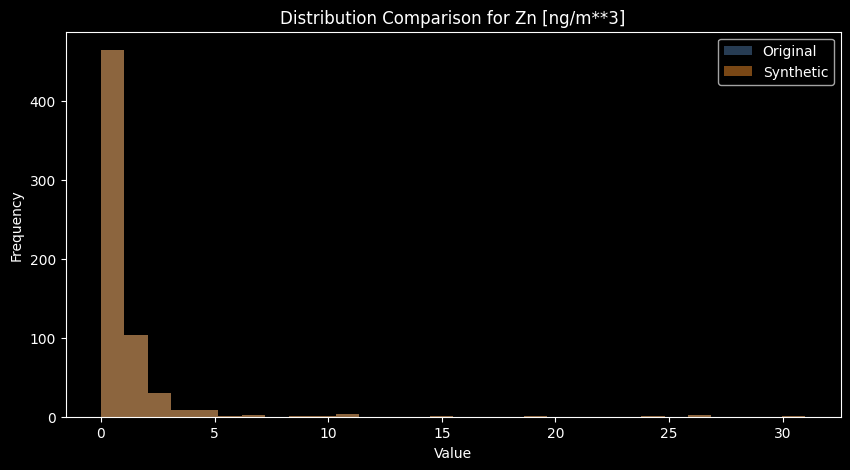

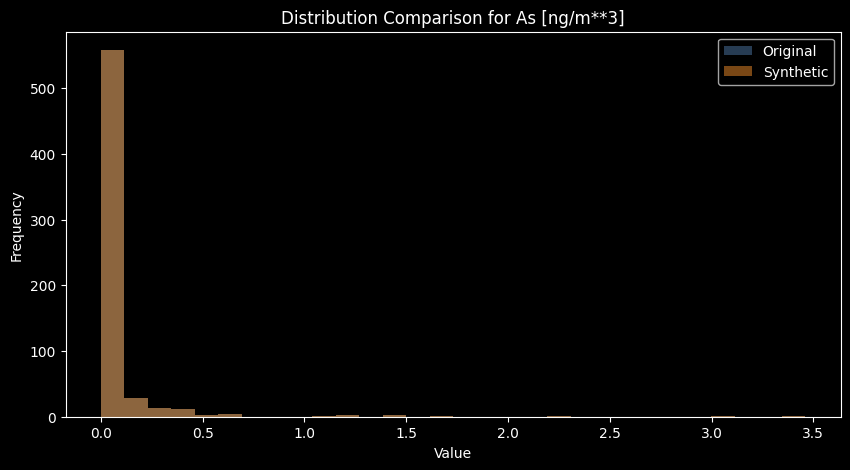

In [77]:
key_cols = ['Zn [ng/m**3]', 'As [ng/m**3]']
for col in key_cols:
    if col in data.columns and col in imputed.columns:
        plt.figure(figsize=(10, 5))
        plt.hist(new_data[col], bins=30, alpha=0.5, label='Original', color='#4e79a7')
        plt.hist(imputed[col], bins=30, alpha=0.5, label='Synthetic', color='#f28e2b')
        plt.title(f'Distribution Comparison for {col}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()


Data Generation Using GaussianCopulaSynthesizer and CTGAN

GuassianCopulaSynthesizer

In [78]:
Gaussian_data = imputed.copy()

metadata = Metadata()

# Detect table from DataFrame
metadata.detect_table_from_dataframe(table_name='marine sediment(Gaussian)', data=Gaussian_data)

# Update 'Size fraction' to categorical
metadata.update_column(table_name='marine sediment(Gaussian)', column_name='Size fraction', sdtype='categorical')

# Calculate duration
Gaussian_data['Duration'] = (Gaussian_data['Date/time end'] - Gaussian_data['Date/Time']).dt.total_seconds()

# Drop the end date column
data = Gaussian_data.drop(columns=['Date/time end'])

# Update metadata to match the modified DataFrame
metadata.remove_column(table_name='marine sediment(Gaussian)', column_name='Date/time end')  # Remove dropped column
metadata.add_column(table_name='marine sediment(Gaussian)', column_name='Duration', sdtype='numerical')  # Add new column
metadata.update_column(table_name='marine sediment(Gaussian)', column_name='Date/Time', sdtype='datetime')  # Update existing column
stats_data = data.iloc[:, 5:]

for col in stats_data:
    if col in stats_data.columns:
        metadata.update_column(column_name=col, sdtype='numerical')
    else:
        print(f"Warning: Column {col} not found in dataset.")
metadata.save_to_json('GuassianCopulaSynthesizer.json')

# Step 3: Initialize and Fit the Gaussian Copula Model
model = GaussianCopulaSynthesizer(metadata=metadata)
model.fit(data)

# Step 4: Generate Synthetic Data
synthetic_data_gaussian = model.sample(num_rows=1000)
# Ensure duration is non-negative
synthetic_data_gaussian['Duration'] = synthetic_data_gaussian['Duration'].clip(lower=0)

# Compute "Date/time end" in synthetic data
synthetic_data_gaussian['Date/time end'] = synthetic_data_gaussian['Date/Time'] + pd.to_timedelta(synthetic_data_gaussian['Duration'], unit='s')

# Step 5: Save Synthetic Data
synthetic_data_gaussian.to_csv('synthetic_data_gaussian_copula.csv', index=False)

print("Synthetic data generation complete. Saved to 'synthetic_data_gaussian_copula.csv'.")
print(synthetic_data_gaussian.shape)

Synthetic data generation complete. Saved to 'synthetic_data_gaussian_copula.csv'.
(1000, 37)


CTGAN

In [81]:
# Initialize metadata
metadata = Metadata()

# Detect table from DataFrame
metadata.detect_table_from_dataframe(table_name='marine sediment', data=imputed)

# Update 'Size fraction' to categorical
metadata.update_column(table_name='marine sediment', column_name='Size fraction', sdtype='categorical')

# Calculate duration
imputed['Duration'] = (imputed['Date/time end'] - imputed['Date/Time']).dt.total_seconds()

# Drop the end date column
data = imputed.drop(columns=['Date/time end'])

# Update metadata to match the modified DataFrame
metadata.remove_column(table_name='marine sediment', column_name='Date/time end')  # Remove dropped column
metadata.update_column(table_name='marine sediment', column_name='Duration', sdtype='numerical')  # Add new column
metadata.update_column(table_name='marine sediment', column_name='Date/Time', sdtype='datetime')  # Update existing column
metadata.save_to_json('ctgan.json')

# Initialize and train the CTGAN model
model = CTGANSynthesizer(metadata=metadata)
model.fit(data)  # Changed from imputed to data

# Generate synthetic data
synthetic_data_ctgan = model.sample(num_rows=1000)

# Ensure duration is non-negative
synthetic_data_ctgan['Duration'] = synthetic_data_ctgan['Duration'].clip(lower=0)

# Compute "Date/time end" in synthetic data
synthetic_data_ctgan['Date/time end'] = synthetic_data_ctgan['Date/Time'] + pd.to_timedelta(synthetic_data_ctgan['Duration'], unit='s')

# Save the corrected synthetic data
synthetic_data_ctgan.to_csv('corrected_synthetic_data.csv', index=False)
print("Corrected synthetic data saved to 'corrected_synthetic_data.csv'.")

Corrected synthetic data saved to 'corrected_synthetic_data.csv'.


Comparison between Original dataset and synthesized dataset

In [82]:
#mean and standard deviation  for original
mean_org = imputed.mean(numeric_only=True).round(3)
std_org  = imputed.std(numeric_only=True).round(3)

#mean and standard deviation  for cleaned data 
mean_gaussian = synthetic_data_gaussian.mean(numeric_only=True).round(3)
std_gaussian  = synthetic_data_gaussian.std(numeric_only=True).round(3)

mean_ctgan = synthetic_data_ctgan.mean(numeric_only=True).round(3)
std_ctgan  = synthetic_data_ctgan.std(numeric_only=True).round(3)
# Combine into a single DataFrame
summary_df = pd.concat([mean_org, std_org, mean_gaussian, std_gaussian,mean_ctgan, std_ctgan ], axis=1)      \
               .reset_index()                      \
               .rename(columns={
                   'index': 'Column',
                   0: 'Mean (Original)',
                   1: 'Std (Original)',
                   2: 'Mean (Gaussian)',
                   3: 'Mean (Gaussian)',
                   4: 'Mean(ctgan)',
                   5: 'Std(ctgan)'
               })

print(summary_df)

                Column  Mean (Original)  Std (Original)  Mean (Gaussian)  \
0                   No         1219.502         202.193      8275025.884   
1         Altitude [m]           42.000           0.000           42.000   
2     Mass v [µg/m**3]           17.358          42.219           17.448   
3        Na+ [µg/m**3]            1.118           1.903            1.073   
4     [NH4]+ [µg/m**3]            0.022           0.036            0.016   
5         K+ [µg/m**3]            0.055           0.085            0.018   
6       Mg2+ [µg/m**3]            0.141           0.266            0.134   
7       Ca2+ [µg/m**3]            0.282           0.404            0.311   
8        Cl- [µg/m**3]            1.938           3.404            1.939   
9     [NO3]- [µg/m**3]            0.192           0.270            0.211   
10   [SO4]2- [µg/m**3]            0.590           0.736            0.598   
11  [C2O4]2- [µg/m**3]            0.010           0.017            0.010   
12       Br-

In [85]:
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import get_column_plot
import json

Gaussian_metadata = 'GuassianCopulaSynthesizer.json'
with open(Gaussian_metadata, 'r') as f:
    gaussian_metadata = json.load(f)

quality_report_gaussian = evaluate_quality(new_data, synthetic_data_gaussian, gaussian_metadata)
print(quality_report_gaussian)
ctgan_metadata = 'ctgan.json'
metadata = json.load(ctgan_metadata)

quality_report_ctgan = evaluate_quality(new_data, synthetic_data_ctgan, metadata)
print(quality_report_ctgan)
fig = get_column_plot(real_data=new_data, synthetic_data=synthetic_data_gaussian, metadata=metadata, column_name='Mass v [µg/m**3]')
fig.show()

AttributeError: 'dict' object has no attribute 'to_dict'

Exploratory Analysis and Stationary Test

In [ ]:
stats_data = synthetic_data_gaussian.iloc[:, 5:]
stats_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Na+ [µg/m**3]       1000 non-null   float64       
 1   [NH4]+ [µg/m**3]    1000 non-null   float64       
 2   K+ [µg/m**3]        1000 non-null   float64       
 3   Mg2+ [µg/m**3]      1000 non-null   float64       
 4   Ca2+ [µg/m**3]      1000 non-null   float64       
 5   Cl- [µg/m**3]       1000 non-null   float64       
 6   [NO3]- [µg/m**3]    1000 non-null   float64       
 7   [SO4]2- [µg/m**3]   1000 non-null   float64       
 8   [C2O4]2- [µg/m**3]  1000 non-null   float64       
 9   Br- [µg/m**3]       1000 non-null   float64       
 10  C org [µg/m**3]     1000 non-null   float64       
 11  EC [µg/m**3]        1000 non-null   float64       
 12  TC [µg/m**3]        1000 non-null   float64       
 13  Ca [ng/m**3]        1000 non-null   float64      

Performing Stationary Test using ADF and PP test

In [ ]:
#ADF test
adf_results = {
    'Chemical': [],
    'ADF Statistic': [],
    'p-value': [],
    'Critical Value 1%': [],
    'Critical Value 5%': [],
    'Critical Value 10%': []
}

# Loop through each column in the DataFrame and perform the ADF test
for column in stats_data.columns:
    adf_result = adfuller(stats_data[column])
    adf_results['Chemical'].append(column)
    adf_results['ADF Statistic'].append(adf_result[0])
    adf_results['p-value'].append(adf_result[1])
    adf_results['Critical Value 1%'].append(adf_result[4]['1%'])
    adf_results['Critical Value 5%'].append(adf_result[4]['5%'])
    adf_results['Critical Value 10%'].append(adf_result[4]['10%'])

# Convert the dictionary to a pandas DataFrame
adf_df = pd.DataFrame(adf_results)

# Set the 'Chemical' column as the index for better readability
adf_df.set_index('Chemical', inplace=True)

# Display the table
print(adf_df)

                    ADF Statistic       p-value  Critical Value 1%  \
Chemical                                                             
Na+ [µg/m**3]          -31.904914  0.000000e+00          -3.436913   
[NH4]+ [µg/m**3]       -31.829661  0.000000e+00          -3.436913   
K+ [µg/m**3]           -32.280128  0.000000e+00          -3.436913   
Mg2+ [µg/m**3]         -15.341626  3.824259e-28          -3.436939   
Ca2+ [µg/m**3]         -11.646944  2.081249e-21          -3.436966   
Cl- [µg/m**3]          -32.065915  0.000000e+00          -3.436913   
[NO3]- [µg/m**3]       -13.491059  3.105647e-25          -3.436946   
[SO4]2- [µg/m**3]      -30.747577  0.000000e+00          -3.436913   
[C2O4]2- [µg/m**3]     -20.319878  0.000000e+00          -3.436919   
Br- [µg/m**3]          -11.670593  1.838876e-21          -3.436946   
C org [µg/m**3]        -19.105469  0.000000e+00          -3.436926   
EC [µg/m**3]           -18.737294  2.029757e-30          -3.436926   
TC [µg/m**3]        

In [ ]:
# PP test
pp_results = {
    'Chemical': [],
    'PP Statistic': [],
    'p-value': [],
    'Critical Value 1%': [],
    'Critical Value 5%': [],
    'Critical Value 10%': []
}

# Loop through each column in the DataFrame and perform the PP test
for column in stats_data.columns:
    series = stats_data[column]
    pp = PhillipsPerron(series)
    pp_results['Chemical'].append(column)
    pp_results['PP Statistic'].append(pp.stat)
    pp_results['p-value'].append(pp.pvalue)
    pp_results['Critical Value 1%'].append(pp.critical_values['1%'])
    pp_results['Critical Value 5%'].append(pp.critical_values['5%'])
    pp_results['Critical Value 10%'].append(pp.critical_values['10%'])

# Convert the dictionary to a pandas DataFrame
pp_df = pd.DataFrame(pp_results)

# Set the 'Chemical' column as the index for better readability
pp_df.set_index('Chemical', inplace=True)

# Display the table
print(pp_df)

                    PP Statistic  p-value  Critical Value 1%  \
Chemical                                                       
Mass v [µg/m**3]      -32.682040      0.0          -3.436913   
Na+ [µg/m**3]         -31.992669      0.0          -3.436913   
[NH4]+ [µg/m**3]      -31.852190      0.0          -3.436913   
K+ [µg/m**3]          -31.088355      0.0          -3.436913   
Mg2+ [µg/m**3]        -32.082931      0.0          -3.436913   
Ca2+ [µg/m**3]        -30.808266      0.0          -3.436913   
Cl- [µg/m**3]         -31.810609      0.0          -3.436913   
[NO3]- [µg/m**3]      -31.369107      0.0          -3.436913   
[SO4]2- [µg/m**3]     -32.202078      0.0          -3.436913   
[C2O4]2- [µg/m**3]    -31.294710      0.0          -3.436913   
Br- [µg/m**3]         -30.197911      0.0          -3.436913   
C org [µg/m**3]       -30.995422      0.0          -3.436913   
EC [µg/m**3]          -32.385855      0.0          -3.436913   
TC [µg/m**3]          -30.497947      0.

In [ ]:
# Step 2: Function to perform Jarque-Bera test on each column of the dataset
def perform_jarque_bera(df):
    results = {}
    for column in df.columns:
        stat, p = jarque_bera(df[column].dropna())
        results[column] = {'statistic': stat, 'p-value': p}
    return pd.DataFrame.from_dict(results, orient='index')

print("Jarque-Bera Test Results:")
jb_results = perform_jarque_bera(stats_data)
print(jb_results)

Jarque-Bera Test Results:
                       statistic        p-value
Mass v [µg/m**3]     2704.948176   0.000000e+00
Na+ [µg/m**3]        3593.636691   0.000000e+00
[NH4]+ [µg/m**3]    13496.076919   0.000000e+00
K+ [µg/m**3]        15767.282480   0.000000e+00
Mg2+ [µg/m**3]       4078.329468   0.000000e+00
Ca2+ [µg/m**3]       1040.692013  1.038964e-226
Cl- [µg/m**3]        3626.341880   0.000000e+00
[NO3]- [µg/m**3]     2221.308772   0.000000e+00
[SO4]2- [µg/m**3]    1100.878724  8.855693e-240
[C2O4]2- [µg/m**3]   3519.470518   0.000000e+00
Br- [µg/m**3]        2937.855043   0.000000e+00
C org [µg/m**3]      2246.580172   0.000000e+00
EC [µg/m**3]         4800.742251   0.000000e+00
TC [µg/m**3]         1341.092044  6.103272e-292
Ca [ng/m**3]        26523.757967   0.000000e+00
Ti [ng/m**3]        64839.527095   0.000000e+00
V [ng/m**3]          8349.231363   0.000000e+00
Cr [ng/m**3]        34181.187651   0.000000e+00
Mn [ng/m**3]         7565.727805   0.000000e+00
Fe [ng/m**3]  

In [ ]:
# Compute the correlation matrix using Pearson correlation
corr_matrix = stats_data.corr()

# Extract and sort correlations for Zinc (Zn)
zn_correlations = corr_matrix['Zn [ng/m**3]'].sort_values(ascending=False)

# Extract and sort correlations for Arsenic (As)
as_correlations = corr_matrix['As [ng/m**3]'].sort_values(ascending=False)

# Display the results
print("Correlations with Zinc (Zn [ng/m**3]):")
print(zn_correlations)
print("\nCorrelations with Arsenic (As [ng/m**3]):")
print(as_correlations)

Correlations with Zinc (Zn [ng/m**3]):
Zn [ng/m**3]          1.000000
Fe [ng/m**3]          0.731493
Pb [ng/m**3]          0.728606
Ca [ng/m**3]          0.723643
Sr [ng/m**3]          0.707534
Cr [ng/m**3]          0.681583
Ti [ng/m**3]          0.669822
Rb [ng/m**3]          0.642197
TC [µg/m**3]          0.534531
La [ng/m**3]          0.525310
C org [µg/m**3]       0.524989
Mass v [µg/m**3]      0.508930
Cu [ng/m**3]          0.475578
Mn [ng/m**3]          0.473047
V [ng/m**3]           0.467900
Ce [ng/m**3]          0.433136
[C2O4]2- [µg/m**3]    0.427990
Ba [ng/m**3]          0.416280
Ni [ng/m**3]          0.401858
[SO4]2- [µg/m**3]     0.353788
Ca2+ [µg/m**3]        0.319992
Se [ng/m**3]          0.281545
EC [µg/m**3]          0.276189
[NO3]- [µg/m**3]      0.276116
K+ [µg/m**3]          0.190393
Mg2+ [µg/m**3]        0.165404
[NH4]+ [µg/m**3]      0.151110
Na+ [µg/m**3]         0.144306
Cl- [µg/m**3]         0.121774
Br- [µg/m**3]         0.089037
As [ng/m**3]          0.041494


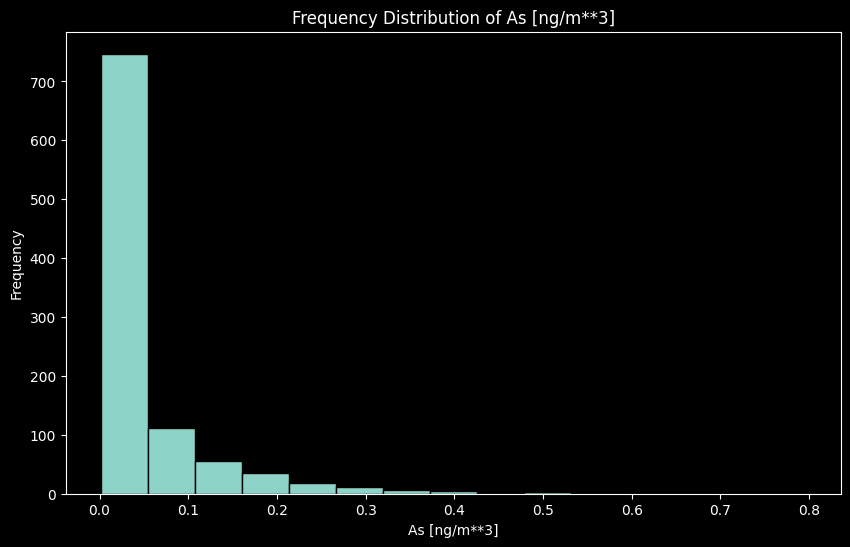

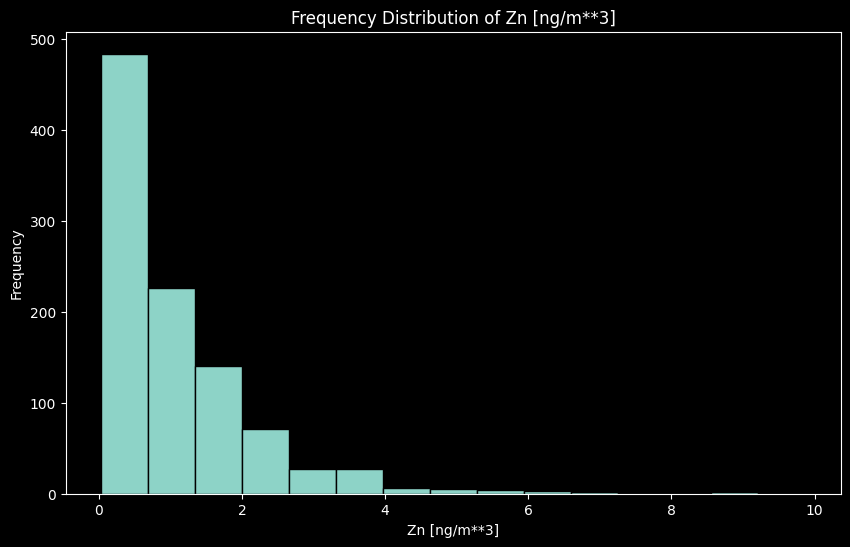

In [ ]:
def plot_histogram(df, column):
    plt.figure(figsize=(10, 6))
    plt.hist(df[column].dropna(), bins=15, edgecolor='black')
    plt.title(f'Frequency Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(stats_data, 'As [ng/m**3]')

plot_histogram(stats_data, 'Zn [ng/m**3]')


K-fold